In [1]:
%pylab inline
import os
import keras
from sklearn import metrics
import numpy as np
import pandas as pd
import keras.backend as K

from time import time

from keras import callbacks
from keras.models import Model
from keras.optimizers import SGD
from keras.layers import Dense, Input
from keras.initializers import VarianceScaling
from tensorflow.keras.layers import Layer, InputSpec

#from scipy.misc import imread
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, normalized_mutual_info_score
     

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [29]:
pip install pillow

Note: you may need to restart the kernel to use updated packages.


In [5]:
# To stop potential randomness
seed = 128
rng = np.random.RandomState(seed)

In [3]:

# to generate gifs
!pip install imageio

In [15]:
# from keras.datasets import mnist
# (x_train, y_train), (x_test, y_test) = mnist.load_data()

In [16]:
! ls -l /kaggle/input/mnistdataset

total 53672
drwxr-xr-x 2 nobody nogroup        0 Sep 22 22:13 t10k-images-idx3-ubyte
-rw-r--r-- 1 nobody nogroup  7840016 Sep 22 22:13 t10k-images.idx3-ubyte
drwxr-xr-x 2 nobody nogroup        0 Sep 22 22:13 t10k-labels-idx1-ubyte
-rw-r--r-- 1 nobody nogroup    10008 Sep 22 22:13 t10k-labels.idx1-ubyte
drwxr-xr-x 2 nobody nogroup        0 Sep 22 22:13 train-images-idx3-ubyte
-rw-r--r-- 1 nobody nogroup 47040016 Sep 22 22:13 train-images.idx3-ubyte
drwxr-xr-x 2 nobody nogroup        0 Sep 22 22:13 train-labels-idx1-ubyte
-rw-r--r-- 1 nobody nogroup    60008 Sep 22 22:13 train-labels.idx1-ubyte


In [2]:
#
# This is a sample Notebook to demonstrate how to read "MNIST Dataset"
#
import numpy as np # linear algebra
import struct
from array import array
from os.path  import join

#
# MNIST Data Loader Class
#
class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath
    
    def read_images_labels(self, images_filepath, labels_filepath):        
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())        
        
        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())        
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images[i][:] = img            
        
        return images, labels
            
    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train),(x_test, y_test) 

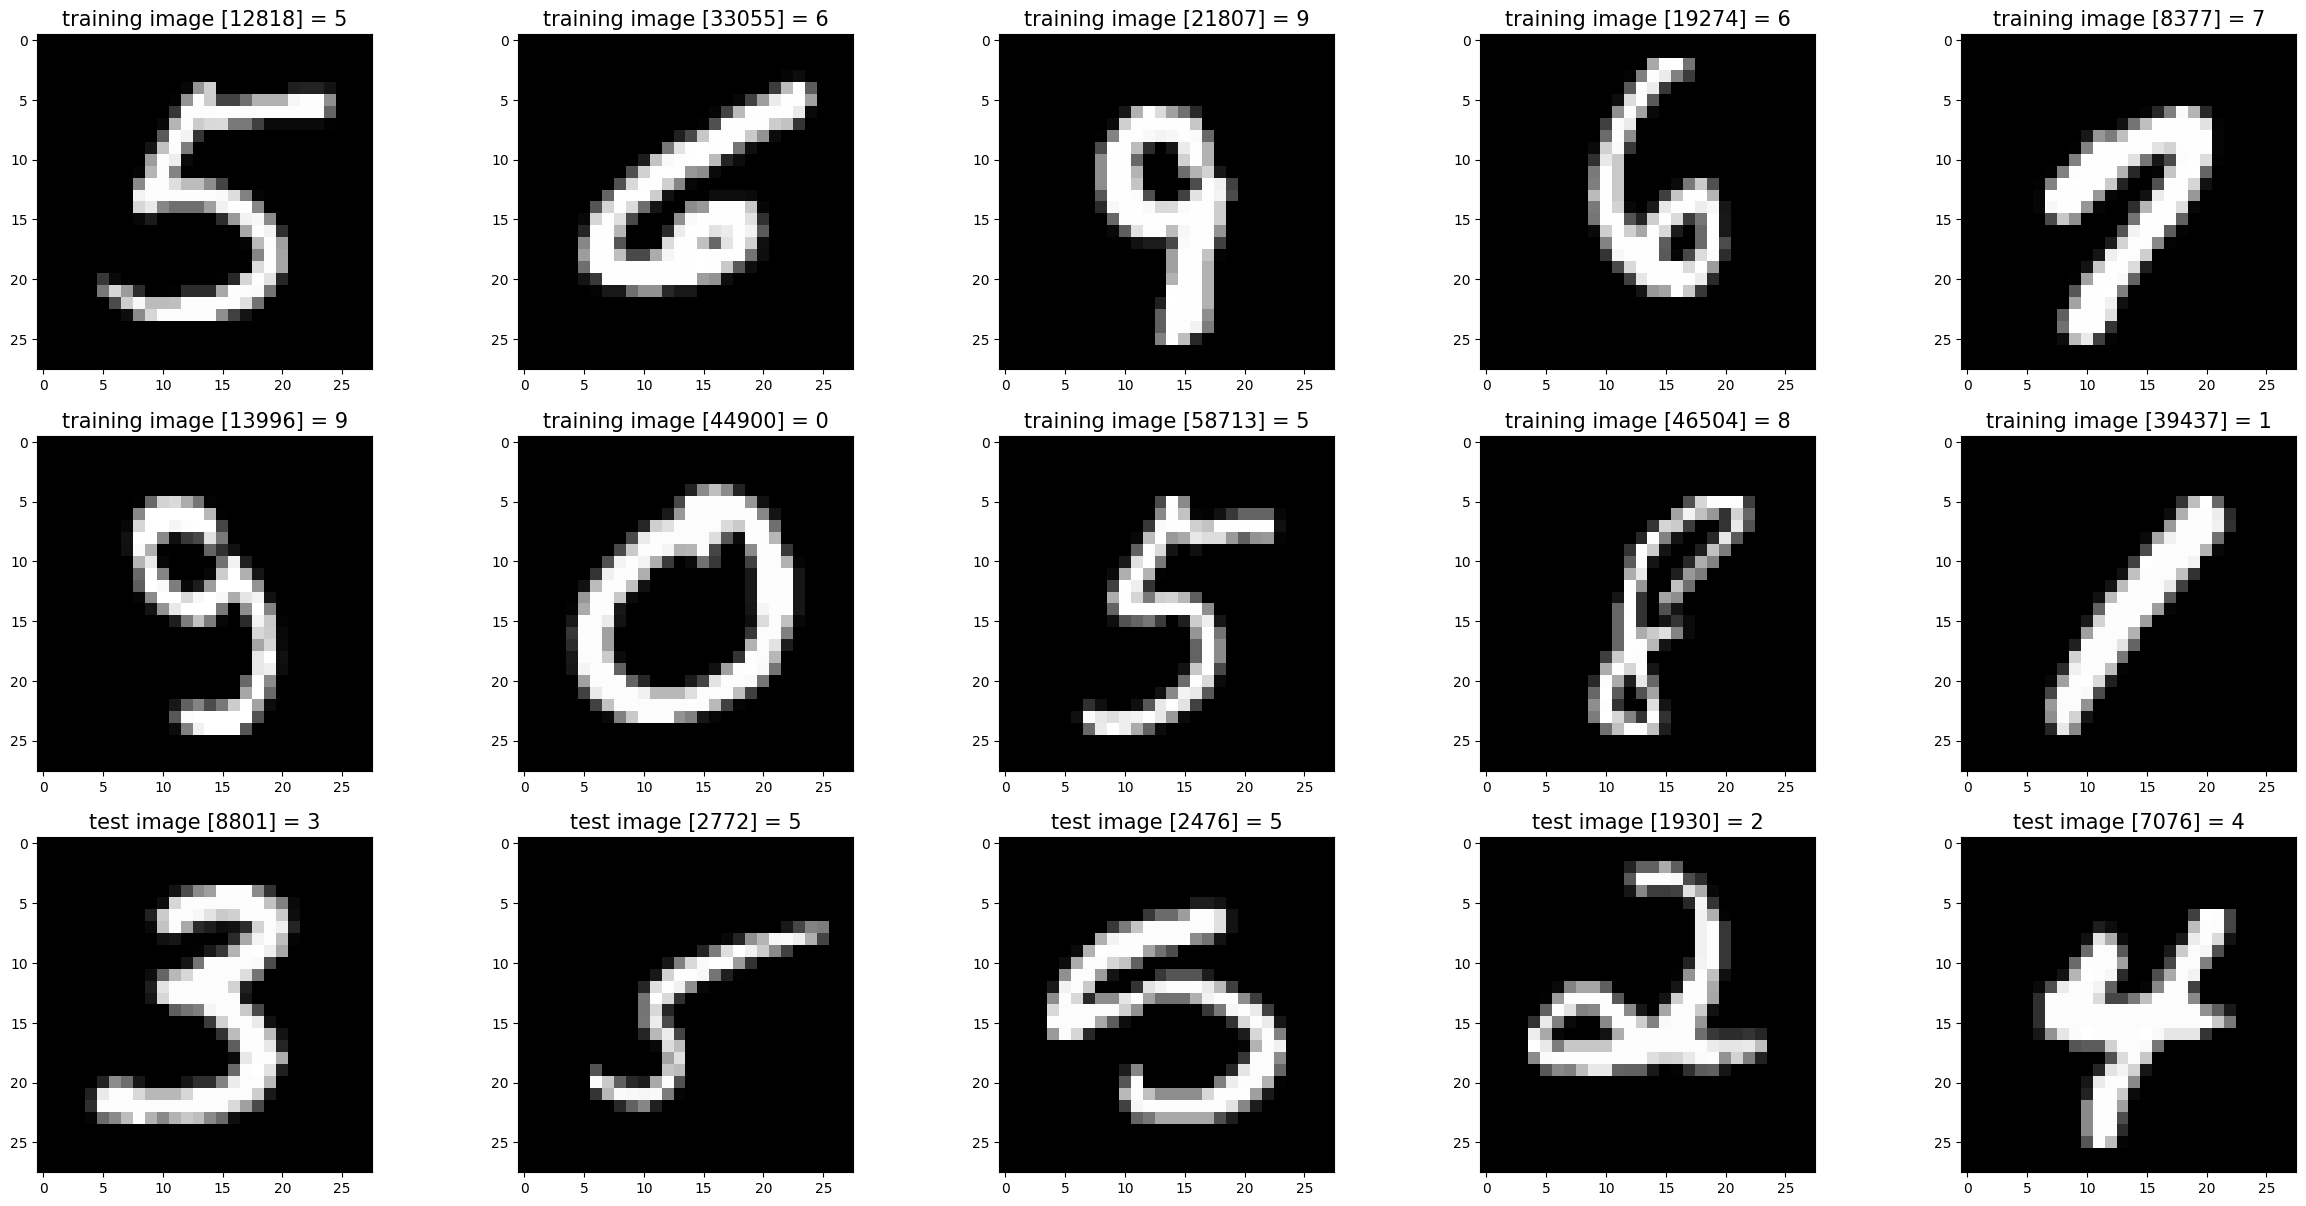

In [3]:
#
# Verify Reading Dataset via MnistDataloader class
#
%matplotlib inline
import random
import matplotlib.pyplot as plt

#
# Set file paths based on added MNIST Datasets
#
input_path = '../input/mnistdataset'
training_images_filepath = join(input_path, 'train-images-idx3-ubyte/train-images-idx3-ubyte')
training_labels_filepath = join(input_path, 'train-labels-idx1-ubyte/train-labels-idx1-ubyte')
test_images_filepath = join(input_path, 't10k-images-idx3-ubyte/t10k-images-idx3-ubyte')
test_labels_filepath = join(input_path, 't10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte')

#
# Helper function to show a list of images with their relating titles
#
def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(30,20))
    index = 1    
    for x in zip(images, title_texts):        
        image = x[0]        
        title_text = x[1]
        plt.subplot(rows, cols, index)        
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 15);        
        index += 1

#
# Load MINST dataset
#
mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()

#
# Show some random training and test images 
#
images_2_show = []
titles_2_show = []
for i in range(0, 10):
    r = random.randint(1, 60000)
    images_2_show.append(x_train[r])
    titles_2_show.append('training image [' + str(r) + '] = ' + str(y_train[r]))    

for i in range(0, 5):
    r = random.randint(1, 10000)
    images_2_show.append(x_test[r])        
    titles_2_show.append('test image [' + str(r) + '] = ' + str(y_test[r]))    

show_images(images_2_show, titles_2_show)

In [9]:
type(x_train)

TypeError: Cannot construct a dtype from an array

In [32]:
x_train = np.stack(images_2_show)

x_train = x_train/ 255.0
x_train = x_train.reshape(-1, 784).astype('float32')



In [33]:
x_test = np.stack(images_2_show)

x_test = x_test/255.0
x_test = x_test.reshape(-1, 784).astype('float32')
#y_train = titles_2_show.label.values


In [36]:
y_train = np.stack(titles_2_show)
#y_train = y_train/255.0
#y_train = y_train.reshape(-1, 784).astype('float32')

In [37]:
split_size = int(x_train.shape[0]*0.7)

x_train, val_x = x_train[:split_size], x_train[split_size:]
y_train, val_y = y_train[:split_size], y_train[split_size:]

In [38]:
km = KMeans( n_clusters=10, n_init=20)
km.fit(x_train)

KMeans(n_clusters=10, n_init=20)

In [39]:
pred = km.predict(val_x)
print(pred)

[8 2 7 6 5]


In [40]:
normalized_mutual_info_score(val_y, pred)

1.0

In [41]:
# this is our input placeholder
input_img = Input(shape=(784,))

# "encoded" is the encoded representation of the input
encoded = Dense(500, activation='relu')(input_img)
encoded = Dense(500, activation='relu')(encoded)
encoded = Dense(2000, activation='relu')(encoded)
encoded = Dense(10, activation='sigmoid')(encoded)

# "decoded" is the lossy reconstruction of the input
decoded = Dense(2000, activation='relu')(encoded)
decoded = Dense(500, activation='relu')(decoded)
decoded = Dense(500, activation='relu')(decoded)
decoded = Dense(784)(decoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense (Dense)               (None, 500)               392500    
                                                                 
 dense_1 (Dense)             (None, 500)               250500    
                                                                 
 dense_2 (Dense)             (None, 2000)              1002000   
                                                                 
 dense_3 (Dense)             (None, 10)                20010     
                                                                 
 dense_4 (Dense)             (None, 2000)              22000     
                                                                 
 dense_5 (Dense)             (None, 500)               100050

In [44]:
#  this model maps an input to its encoded representation
encoder = Model(input_img, encoded)
autoencoder.compile(optimizer='adam', loss='mse')

In [45]:
train_history = autoencoder.fit(x_train, x_train, epochs=500, batch_size=2048, validation_data=(val_x, val_x))

Epoch 1/500
1/1 [==============================] - 2s 2s/step - loss: 0.1071 - val_loss: 0.1086
Epoch 2/500
1/1 [==============================] - 0s 64ms/step - loss: 0.1026 - val_loss: 0.1029
Epoch 3/500
1/1 [==============================] - 0s 65ms/step - loss: 0.0966 - val_loss: 0.0940
Epoch 4/500
1/1 [==============================] - 0s 52ms/step - loss: 0.0871 - val_loss: 0.0851
Epoch 5/500
1/1 [==============================] - 0s 55ms/step - loss: 0.0772 - val_loss: 0.0847
Epoch 6/500
1/1 [==============================] - 0s 55ms/step - loss: 0.0749 - val_loss: 0.0778
Epoch 7/500
1/1 [==============================] - 0s 58ms/step - loss: 0.0666 - val_loss: 0.0741
Epoch 8/500
1/1 [==============================] - 0s 52ms/step - loss: 0.0623 - val_loss: 0.0739
Epoch 9/500
1/1 [==============================] - 0s 56ms/step - loss: 0.0615 - val_loss: 0.0743
Epoch 10/500
1/1 [==============================] - 0s 54ms/step - loss: 0.0610 - val_loss: 0.0750
Epoch 11/500
1/1 [===

In [47]:
pred_auto_train = encoder.predict(x_train)
pred_auto = encoder.predict(val_x)

1/1 [==============================] - 0s 29ms/step


In [48]:
km.fit(pred_auto_train)
pred = km.predict(pred_auto)

In [49]:
normalized_mutual_info_score(val_y, pred)

1.0